In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import models
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
# to share the GPU resources for multiple sessions
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True # dynamically grow the memory used on the GPU
config.log_device_placement = True # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

%matplotlib inline

2023-06-02 05:33:42.702164: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-02 05:33:42.842753: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GRID A100D-16C, pci bus id: 0000:02:01.0, compute capability: 8.0



2023-06-02 05:33:44.721908: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-02 05:33:44.728456: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-02 05:33:44.759806: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-02 05:33:44.760012: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must 

In [2]:
my_data_dir = 'dataset/cell_images'

In [3]:
os.listdir(my_data_dir)

['train', 'test']

In [4]:
test_path = my_data_dir+'/test/'
train_path = my_data_dir+'/train/'

In [5]:
os.listdir(train_path)

['uninfected', 'parasitized']

In [6]:
len(os.listdir(train_path+'/uninfected/'))

12480

In [7]:
len(os.listdir(train_path+'/parasitized/'))

12480

In [8]:
os.listdir(train_path+'/parasitized')[5604]

'C66P27N_ThinF_IMG_20150818_164008_cell_156.png'

In [9]:
para_img= imread(train_path+
                 '/parasitized/'+
                 os.listdir(train_path+'/parasitized')[5604])

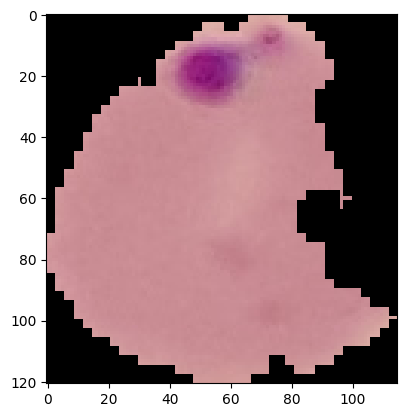

In [10]:
plt.imshow(para_img)

In [11]:
uninfe_img= imread(train_path+
                 '/uninfected/'+
                 os.listdir(train_path+'/uninfected')[5604])

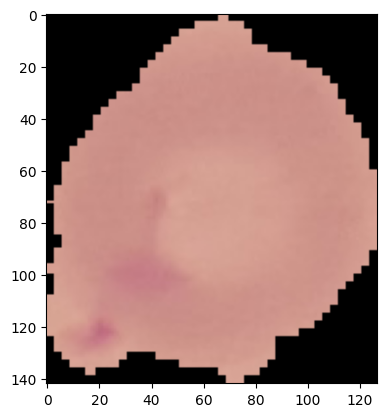

In [12]:
plt.imshow(uninfe_img)

In [13]:
# Checking the image dimensions
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'/uninfected'):
    img = imread(test_path+'/uninfected'+'/'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

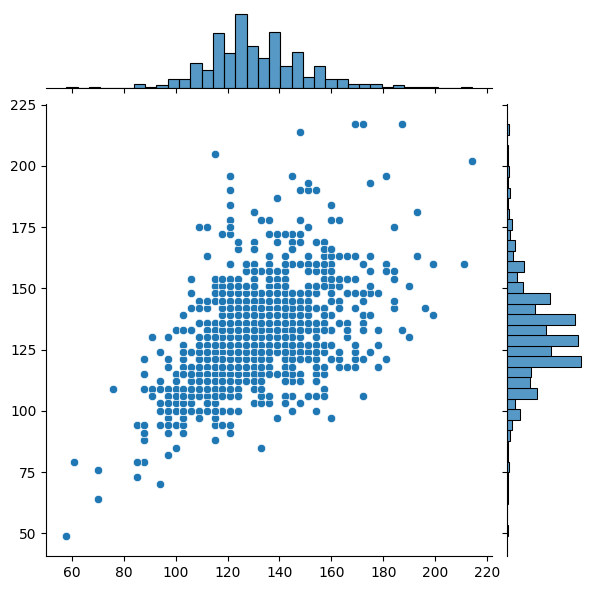

In [14]:
sns.jointplot(x=dim1,y=dim2)

In [15]:
image_shape = (130,130,3)

In [18]:
model = models.Sequential()
model.add(layers.Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))


model.add(layers.Flatten())

model.add(layers.Dense(128))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))


model.add(layers.Dense(64))
model.add(layers.Activation('relu'))

model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 60, 32)        51232     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 16)      

In [20]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [21]:
batch_size = 16

In [22]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 24958 images belonging to 2 classes.


In [23]:
len(train_image_gen.classes)

24958

In [24]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 2600 images belonging to 2 classes.


In [25]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [30]:
results = model.fit(train_image_gen,epochs=4,
                              validation_data=test_image_gen
                             )

Epoch 1/4
1560/1560 [==============================] - 136s 87ms/step - loss: 0.1853 - accuracy: 0.9425 - val_loss: 0.1864 - val_accuracy: 0.9427
Epoch 2/4
1560/1560 [==============================] - 126s 80ms/step - loss: 0.1710 - accuracy: 0.9478 - val_loss: 0.1642 - val_accuracy: 0.9496
Epoch 3/4
1560/1560 [==============================] - 124s 80ms/step - loss: 0.1635 - accuracy: 0.9481 - val_loss: 0.1739 - val_accuracy: 0.9408
Epoch 4/4
1560/1560 [==============================] - 121s 78ms/step - loss: 0.1637 - accuracy: 0.9499 - val_loss: 0.1729 - val_accuracy: 0.9438


In [31]:
losses = pd.DataFrame(model.history.history)

<Axes: >

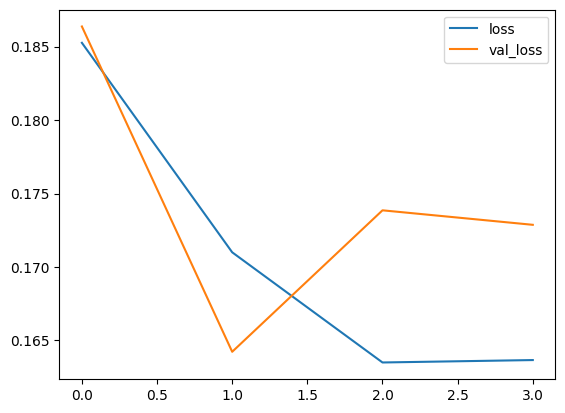

In [32]:
losses[['loss','val_loss']].plot()

In [33]:
model.evaluate(test_image_gen)

163/163 [==============================] - 11s 70ms/step - loss: 0.1735 - accuracy: 0.9423


[0.1734727919101715, 0.942307710647583]

In [34]:
pred_probabilities = model.predict(test_image_gen)

163/163 [==============================] - 12s 70ms/step


In [35]:
test_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [36]:
predictions = pred_probabilities > 0.5


In [37]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1300
           1       0.95      0.95      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



In [38]:
confusion_matrix(test_image_gen.classes,predictions)

array([[1230,   70],
       [  65, 1235]])

1/1 [==============================] - 0s 122ms/step


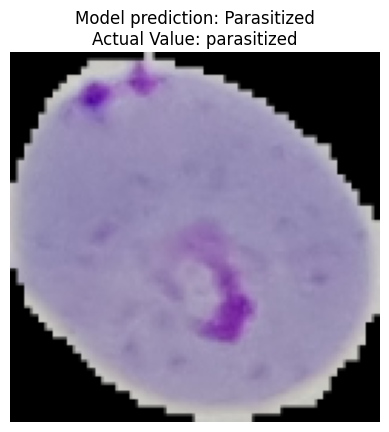

In [39]:
import random
import tensorflow as tf
list_dir=["uninfected","parasitized"]
dir_=(random.choice(list_dir))
para_img= imread(train_path+
                 '/'+dir_+'/'+
                 os.listdir(train_path+'/'+dir_)[random.randint(0,100)])
img  = tf.convert_to_tensor(np.asarray(para_img))
img = tf.image.resize(img,(130,130))
img=img.numpy()
pred=bool(model.predict(img.reshape(1,130,130,3))<0.5 )
plt.title("Model prediction: "+("Parasitized" if pred  else "Uninfected")+"\nActual Value: "+str(dir_))
plt.axis("off")
plt.imshow(img)
plt.show()